In [2]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 3.2 MB/s eta 0:00:00


✅ Libraries imported.
🔄 Loading preprocessed data from: /content/drive/MyDrive/Colab Notebooks/datasets/processed/
✅ All data files loaded successfully.

--- Processing LogisticRegression ---
✅ Training complete in 568.82 seconds.
💾 Classification report saved to: /content/drive/MyDrive/Colab Notebooks/results/classification_reports/LogisticRegression_classification_report.txt
💾 Confusion matrix saved to: /content/drive/MyDrive/Colab Notebooks/results/figures/modeling/LogisticRegression_confusion_matrix.png
💾 Model saved to: /content/drive/MyDrive/Colab Notebooks/results/saved_models/LogisticRegression_model.joblib

--- Processing DecisionTree ---
✅ Training complete in 2.46 seconds.
💾 Classification report saved to: /content/drive/MyDrive/Colab Notebooks/results/classification_reports/DecisionTree_classification_report.txt
💾 Confusion matrix saved to: /content/drive/MyDrive/Colab Notebooks/results/figures/modeling/DecisionTree_confusion_matrix.png
💾 Model saved to: /content/drive/MyDr

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [13:36:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


✅ Training complete in 31.03 seconds.
💾 Classification report saved to: /content/drive/MyDrive/Colab Notebooks/results/classification_reports/XGBoost_classification_report.txt
💾 Confusion matrix saved to: /content/drive/MyDrive/Colab Notebooks/results/figures/modeling/XGBoost_confusion_matrix.png
💾 Model saved to: /content/drive/MyDrive/Colab Notebooks/results/saved_models/XGBoost_model.joblib


--- Final Model Performance Comparison ---
                Model  Test Accuracy  Test F1 (Weighted)  Training Time (s)
0  LogisticRegression       0.939359            0.939209         568.820960
1        DecisionTree       0.984607            0.984790           2.463123
2        RandomForest       0.986020            0.986236          10.022250
3             XGBoost       0.986867            0.987174          31.031543

💾 Comparison results saved to: /content/drive/MyDrive/Colab Notebooks/results/model_comparison_results_v2.csv


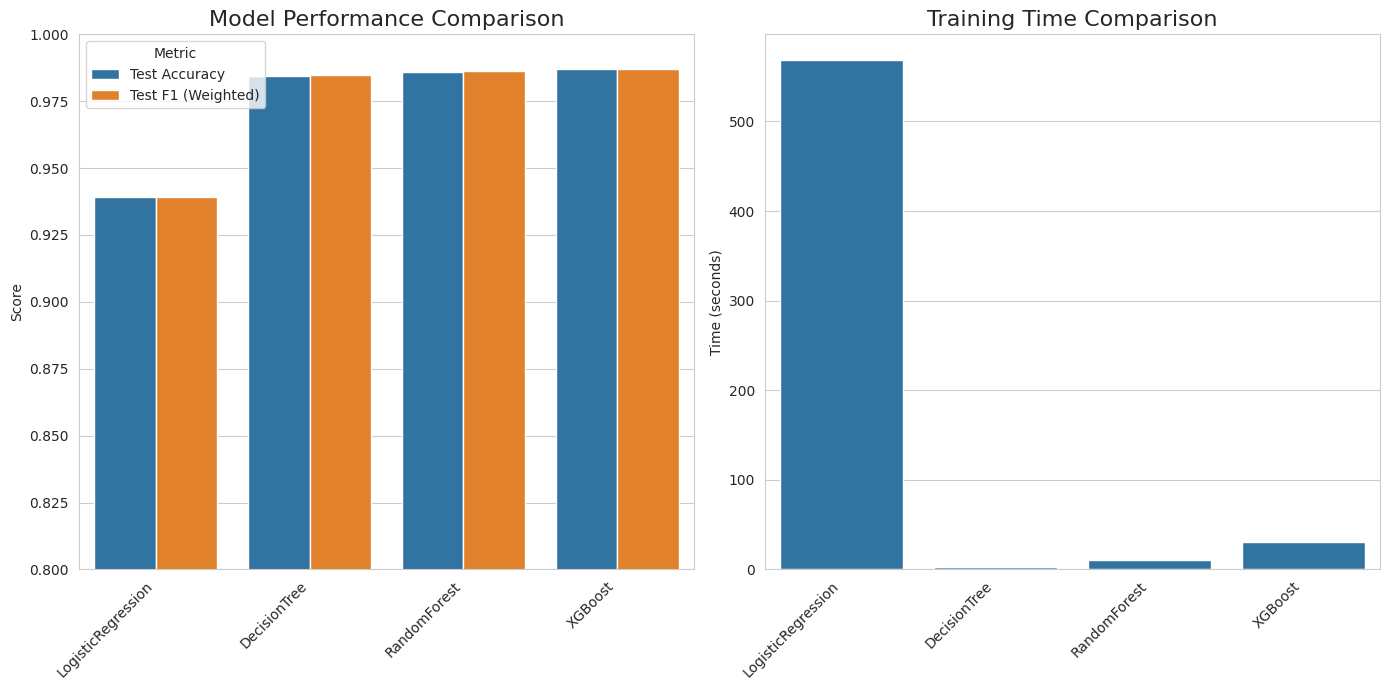

💾 Comparison plot saved to: /content/drive/MyDrive/Colab Notebooks/results/figures/modeling/model_performance_comparison_v2.png

--- Script Finished Successfully ---


In [1]:
# -*- coding: utf-8 -*-
"""
5- ML Model Training and Evaluation (V2 - Improved)

This script incorporates several improvements:
1. A wrapper function for clean, reusable training and evaluation logic.
2. Training time tracking for each model.
3. Early stopping for XGBoost to improve efficiency and prevent overfitting.
4. Saving detailed classification reports to individual text files.
"""

# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import time # For tracking training time

# Model-specific imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

print("✅ Libraries imported.")

# --- 2. Configuration and Path Definitions ---
PROCESSED_DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/datasets/processed/'
RESULTS_PATH = '/content/drive/MyDrive/Colab Notebooks/results/'
MODELS_PATH = os.path.join(RESULTS_PATH, 'saved_models/')
REPORTS_PATH = os.path.join(RESULTS_PATH, 'classification_reports/')
FIGURES_PATH = os.path.join(RESULTS_PATH, 'figures/modeling/')

# Create output directories if they don't exist
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


# --- 3. Load the Preprocessed "Light" Dataset ---
print(f"🔄 Loading preprocessed data from: {PROCESSED_DATA_PATH}")
try:
    X_train = joblib.load(os.path.join(PROCESSED_DATA_PATH, 'X_train_resampled.joblib'))
    y_train = joblib.load(os.path.join(PROCESSED_DATA_PATH, 'y_train_resampled.joblib'))
    X_val = joblib.load(os.path.join(PROCESSED_DATA_PATH, 'X_val_scaled.joblib'))
    y_val = joblib.load(os.path.join(PROCESSED_DATA_PATH, 'y_val.joblib'))
    X_test = joblib.load(os.path.join(PROCESSED_DATA_PATH, 'X_test_scaled.joblib'))
    y_test = joblib.load(os.path.join(PROCESSED_DATA_PATH, 'y_test.joblib'))
    label_encoder = joblib.load(os.path.join(PROCESSED_DATA_PATH, 'label_encoder.joblib'))
    print("✅ All data files loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ ERROR: Data file not found. {e}")
    # exit()


# --- 4. Define the Wrapper Function for Training and Evaluation ---
def train_and_evaluate_model(model_name, model, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Trains a model, tracks time, evaluates performance, and saves all artifacts.
    """
    print(f"\n--- Processing {model_name} ---")

    # a. Track Training Time
    start_time = time.time()

    # Special handling for XGBoost early stopping
    if model_name == "XGBoost":
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    else:
        model.fit(X_train, y_train)

    training_time = time.time() - start_time
    print(f"✅ Training complete in {training_time:.2f} seconds.")

    # b. Evaluate on Test Set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    report_text = classification_report(y_test, y_test_pred, target_names=label_encoder.classes_)
    cm = confusion_matrix(y_test, y_test_pred)

    # c. Save Classification Report
    report_save_path = os.path.join(REPORTS_PATH, f'{model_name}_classification_report.txt')
    with open(report_save_path, 'w') as f:
        f.write(f"Classification Report for {model_name}\n")
        f.write(f"Training Time: {training_time:.2f} seconds\n\n")
        f.write(report_text)
    print(f"💾 Classification report saved to: {report_save_path}")

    # d. Plot and Save Confusion Matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name} (Test Set)', fontsize=16)
    plt.ylabel('Actual Label'); plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    cm_figure_path = os.path.join(FIGURES_PATH, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_figure_path, dpi=300, bbox_inches='tight')
    plt.close() # Close plot to avoid displaying it here
    print(f"💾 Confusion matrix saved to: {cm_figure_path}")

    # e. Save the Trained Model
    model_save_path = os.path.join(MODELS_PATH, f'{model_name}_model.joblib')
    joblib.dump(model, model_save_path)
    print(f"💾 Model saved to: {model_save_path}")

    # f. Return results for final comparison
    return {
        'Model': model_name,
        'Test Accuracy': test_accuracy,
        'Test F1 (Weighted)': test_f1_weighted,
        'Training Time (s)': training_time
    }


# --- 5. Define and Run Models ---
# Note the addition of 'early_stopping_rounds' for XGBoost
models_to_train = {
    "LogisticRegression": LogisticRegression(random_state=42, solver='liblinear', max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', early_stopping_rounds=10)
}

# --- Sanitize Feature Names Before Training ---
def sanitize_column_names(df):
    """
    Replace unsupported characters in column names to ensure compatibility with models like XGBoost.
    """
    df.columns = df.columns.astype(str).str.replace(r'[\[\]<>]', '_', regex=True)
    return df

# Apply sanitization to all input sets
X_train = sanitize_column_names(df=X_train)
X_val = sanitize_column_names(X_val)
X_test = sanitize_column_names(X_test)

# --- Main loop to run the process for each model ---
all_results = []
for name, model in models_to_train.items():
    result = train_and_evaluate_model(model_name=name, model=model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test)
    all_results.append(result)

# --- 6. Final Model Comparison ---
print("\n\n--- Final Model Performance Comparison ---")
results_df = pd.DataFrame(all_results)
print(results_df)

# Save results to a CSV file
results_df.to_csv(os.path.join(RESULTS_PATH, 'model_comparison_results_v2.csv'), index=False)
print(f"\n💾 Comparison results saved to: {os.path.join(RESULTS_PATH, 'model_comparison_results_v2.csv')}")

# Plot the comparison results
plt.figure(figsize=(14, 7))
# Subplot 1: Accuracy and F1-Score
plt.subplot(1, 2, 1)
melted_df_perf = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score',
                                 value_vars=['Test Accuracy', 'Test F1 (Weighted)'])
sns.barplot(data=melted_df_perf, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Score'); plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.8, 1.0)
# Subplot 2: Training Time
plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x='Model', y='Training Time (s)')
plt.title('Training Time Comparison', fontsize=16)
plt.ylabel('Time (seconds)'); plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() # Adjust layout to make room for rotated labels

comparison_figure_path = os.path.join(FIGURES_PATH, 'model_performance_comparison_v2.png')
plt.savefig(comparison_figure_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"💾 Comparison plot saved to: {comparison_figure_path}")

print("\n--- Script Finished Successfully ---")